# Imports

In [1]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.config.run_functions_eagerly(True)
from sklearn.preprocessing import StandardScaler

# Creating Directory 

In [2]:
parent_dir = "D:\Programming\python\my_ai_lab\dataset\PEMS"
directory = ["train","validate","test"]
data_dir = []

for dir in directory:
    path = os.path.join(parent_dir, dir)
    data_dir.append(path)
    os.makedirs(path, exist_ok = True)
print(data_dir)

['D:\\Programming\\python\\my_ai_lab\\dataset\\PEMS\\train', 'D:\\Programming\\python\\my_ai_lab\\dataset\\PEMS\\validate', 'D:\\Programming\\python\\my_ai_lab\\dataset\\PEMS\\test']


# Data Loading

In [3]:
train_file_name = ["gt_2011.csv","gt_2012.csv","gt_2013.csv","gt_2014.csv","gt_2015.csv"]
#reading 5 file into single data frame



def data_loader_from_multiple_file(filename, filedir):
    data_pd = None
    frames = []
    for file in train_file_name:
        file = os.path.join(parent_dir,file)
        read_file = pd.read_csv (file)
        frames.append(read_file)

        data_pd = pd.concat(frames,axis = 0)
    return data_pd

data_pd = data_loader_from_multiple_file(train_file_name, parent_dir)

columns = [col for col in data_pd.columns]

In [4]:
def shuffle(data,no_of_shuffle=100):
    data_tf = tf.convert_to_tensor(data)
    for i in range(no_of_shuffle):
        data_tf = tf.random.shuffle(data_tf, seed = 42)
    return pd.DataFrame(data = data_tf)

shuffled_data_pd = shuffle(data_pd,100)


# Data splitting

In [5]:
data_np = shuffled_data_pd.to_numpy()
train_np, val_np, test_np = np.split(data_np, [int(0.8*len(data_np)), int(0.9*len(data_np))])

In [6]:
train_pd = pd.DataFrame(data = train_np,columns = columns)

val_pd = pd.DataFrame(data = val_np,columns = columns)
test_pd = pd.DataFrame(data = test_np,columns = columns)


In [7]:
X_train_pd = train_pd.drop(columns = 'NOX',)
y_train_pd = train_pd.iloc[:,10:]

X_val_pd = val_pd.drop(columns = 'NOX',)
y_val_pd = val_pd.iloc[:,10:]

X_test_pd = test_pd.drop(columns = 'NOX',)
y_test_pd = test_pd.iloc[:,10:]

In [8]:
X_train_np = X_train_pd.to_numpy()
y_train_np = y_train_pd.to_numpy()

X_val_np = X_val_pd.to_numpy()
y_val_np = y_val_pd.to_numpy()

X_test_np = X_test_pd.to_numpy()
y_test_np = y_test_pd.to_numpy()

# Data preprocessing

In [9]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()

scaler_x.fit(X_train_np)
scaler_y.fit(y_train_np)


StandardScaler()

In [10]:
X_train_np = scaler_x.transform(X_train_np)
y_train_np = scaler_y.transform(y_train_np)

X_val_np = scaler_x.transform(X_val_np)
y_val_np = scaler_y.transform(y_val_np)

X_test_np = scaler_x.transform(X_test_np)
y_test_np = scaler_y.transform(y_test_np)

y_test_np.shape

(3674, 1)

# Feed forward model

In [11]:
def pems_model():
  
    initializer = keras.initializers.HeNormal(seed = 42)
    model = tf.keras.Sequential([
    
    keras.layers.InputLayer(input_shape = [None, 10]),
    keras.layers.Dense(64,kernel_initializer=initializer, activation='elu'),
    keras.layers.Dropout(0.20),
    #tf.keras.layers.LayerNormalization(axis=1),
    keras.layers.Dense(64 ,kernel_initializer=initializer, activation='elu'),
    keras.layers.Dropout(0.20),
    #keras.layers.Dense(64 ,kernel_initializer=initializer, activation='elu'),
    #keras.layers.Dropout(0.20),
    #tf.keras.layers.LayerNormalization(axis=1),
    keras.layers.Dense(1, kernel_initializer=initializer ,activation='elu')
  ])


    optimizer = keras.optimizers.SGD(learning_rate=0.0001,momentum = 0.9)
    loss = keras.losses.MeanSquaredError()


    model.compile(loss= loss, optimizer= optimizer)
    return model

pems_model = pems_model()

In [12]:
pems_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, None, 64)          704       
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 dense_1 (Dense)             (None, None, 64)          4160      
                                                                 
 dropout_1 (Dropout)         (None, None, 64)          0         
                                                                 
 dense_2 (Dense)             (None, None, 1)           65        
                                                                 
Total params: 4,929
Trainable params: 4,929
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Define some useful callbacks
#Reduce learning rate when a metric has stopped improving.
reducelrp = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=0, mode='auto', min_delta=0.001, cooldown=0, min_lr=0.000000001)
# Stop training when a monitored quantity has stopped improving. 
# By default, mode is set to ‘auto‘ and knows that you want to minimize loss or maximize accuracy.
early_stopping_monitor=keras.callbacks.EarlyStopping(monitor='val_loss',verbose=1, patience=10, baseline=0.4,min_delta = 0.001 )
# Save the model after every epoch.
best_trained_model_file= 'pems_model.h5'
checkpoint = keras.callbacks.ModelCheckpoint(best_trained_model_file, verbose=0, monitor='val_loss',save_best_only=True, mode='auto')  
#place callbacks want to enable on this list
callbacks= [checkpoint,reducelrp, checkpoint] #[checkpoint,

In [14]:
#fitting the model

history = pems_model.fit( x = X_train_np, y = y_train_np, epochs=100,
  validation_data = (X_val_np,y_val_np) ,callbacks = callbacks,verbose = 'auto')


Epoch 1/100


D:\Programming\python\my_ai_lab\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


919/919 [==============================] - 17s 19ms/step - loss: 1.0330 - val_loss: 0.5457 - lr: 1.0000e-04
Epoch 2/100
919/919 [==============================] - 16s 18ms/step - loss: 0.6774 - val_loss: 0.4371 - lr: 1.0000e-04
Epoch 3/100
919/919 [==============================] - 18s 19ms/step - loss: 0.5546 - val_loss: 0.4027 - lr: 1.0000e-04
Epoch 4/100
919/919 [==============================] - 13s 14ms/step - loss: 0.5008 - val_loss: 0.3867 - lr: 1.0000e-04
Epoch 5/100
919/919 [==============================] - 14s 15ms/step - loss: 0.4793 - val_loss: 0.3767 - lr: 1.0000e-04
Epoch 6/100
919/919 [==============================] - 12s 14ms/step - loss: 0.4650 - val_loss: 0.3698 - lr: 1.0000e-04
Epoch 7/100
919/919 [==============================] - 12s 14ms/step - loss: 0.4568 - val_loss: 0.3655 - lr: 1.0000e-04
Epoch 8/100
919/919 [==============================] - 12s 13ms/step - loss: 0.4493 - val_loss: 0.3600 - lr: 1.0000e-04
Epoch 9/100
919/919 [==============================]

Epoch 69/100
919/919 [==============================] - 15s 16ms/step - loss: 0.3473 - val_loss: 0.2855 - lr: 1.0000e-07
Epoch 70/100
919/919 [==============================] - 12s 13ms/step - loss: 0.3446 - val_loss: 0.2855 - lr: 1.0000e-07
Epoch 71/100
919/919 [==============================] - 12s 13ms/step - loss: 0.3472 - val_loss: 0.2855 - lr: 1.0000e-07
Epoch 72/100
919/919 [==============================] - 12s 13ms/step - loss: 0.3448 - val_loss: 0.2855 - lr: 1.0000e-08
Epoch 73/100
919/919 [==============================] - 12s 13ms/step - loss: 0.3468 - val_loss: 0.2855 - lr: 1.0000e-08
Epoch 74/100
919/919 [==============================] - 12s 13ms/step - loss: 0.3442 - val_loss: 0.2855 - lr: 1.0000e-08
Epoch 75/100
919/919 [==============================] - 12s 13ms/step - loss: 0.3477 - val_loss: 0.2855 - lr: 1.0000e-08
Epoch 76/100
919/919 [==============================] - 12s 13ms/step - loss: 0.3471 - val_loss: 0.2855 - lr: 1.0000e-08
Epoch 77/100
919/919 [==========

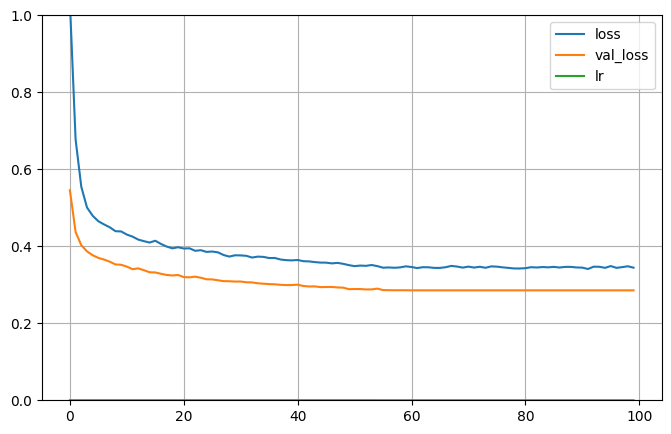

<Figure size 640x480 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.savefig('pems_performance.pdf')
plt.show()


In [16]:
model_load = keras.models.load_model('pems_model.h5')

In [21]:
y_predict = pems_model.predict(X_test_np)

 40/115 [=========>....................] - ETA: 0s

D:\Programming\python\my_ai_lab\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


115/115 [==============================] - 0s 3ms/step


In [22]:
y_predict = pd.DataFrame(data = y_predict)
y_test_tf = pd.DataFrame(data = y_test_np)

In [23]:
y_predict.head()

,0
0,0.673895
1,2.294915
2,0.191966
3,1.044357
4,-0.771488


In [24]:
y_test_tf.head()

,0
0,0.976421
1,0.414376
2,0.294523
3,0.111756
4,-1.163431
